In [12]:
%pip install wordcloud

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cyrilkevin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv('Sentiment.csv')
# Keeping only the neccessary columns
data = data[['text','sentiment']]
data.head()

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive


In [3]:
# Splitting the dataset into train and test set
train, test = train_test_split(data,test_size = 0.1)
# Removing neutral sentiments
train = train[train.sentiment != "Neutral"]

Positive words


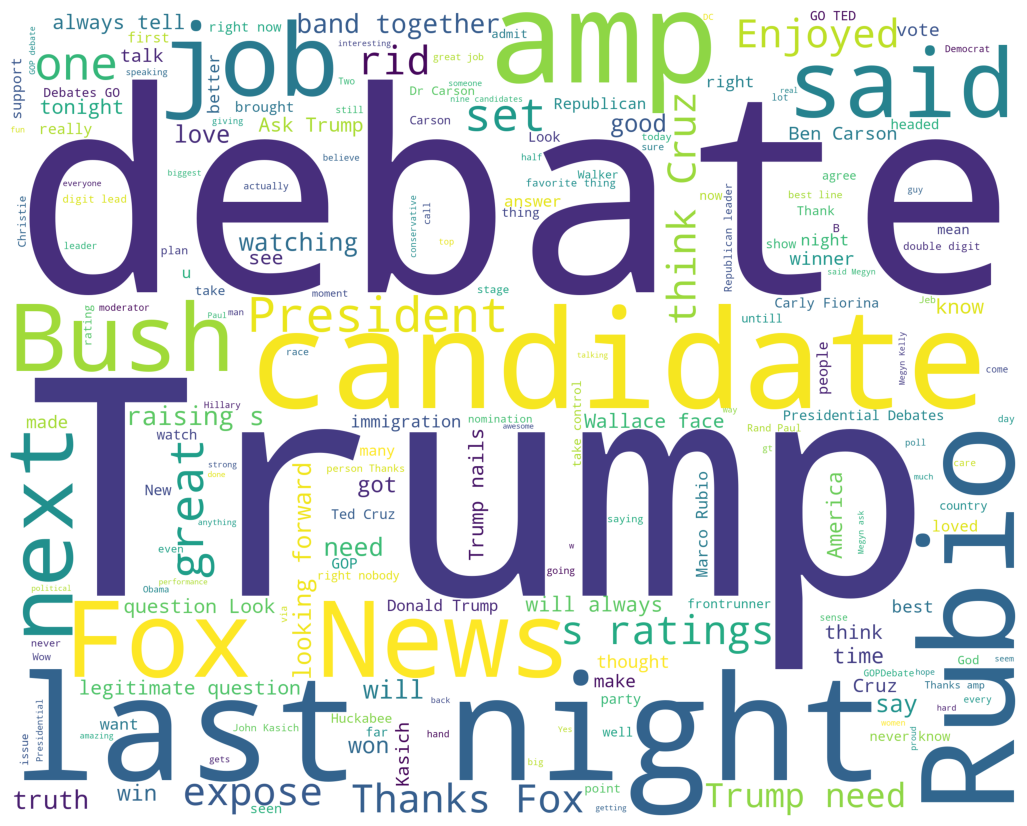

Negative words


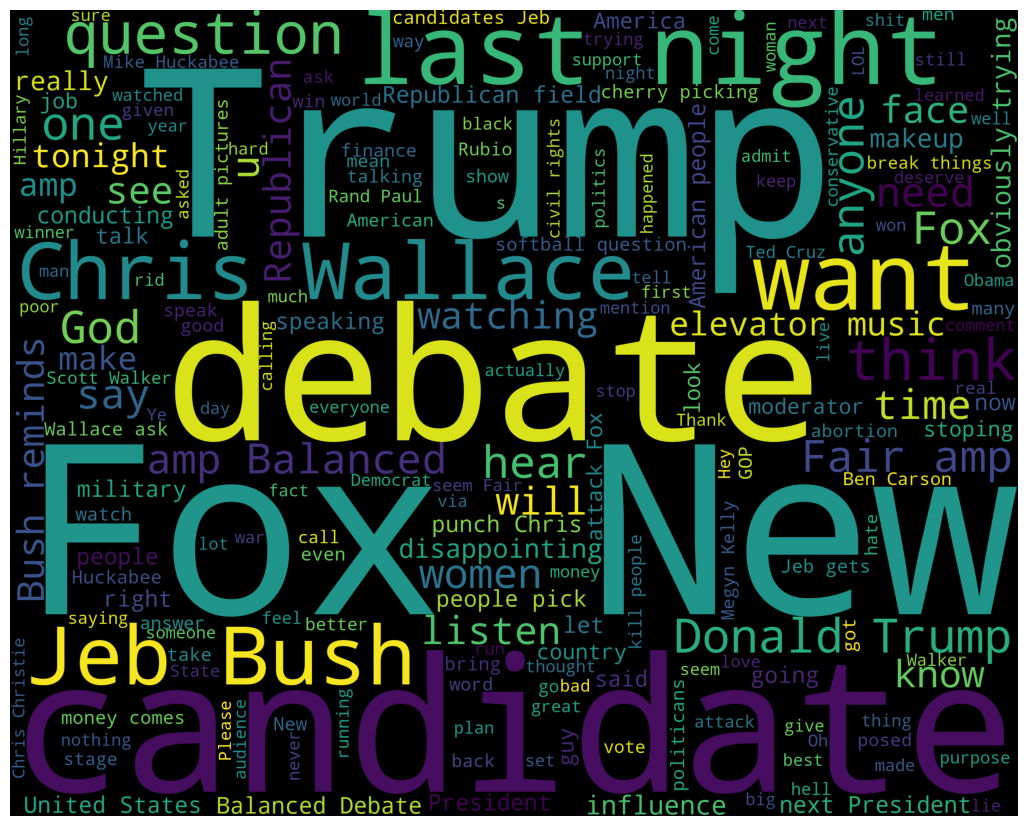

In [4]:
train_pos = train[ train['sentiment'] == 'Positive']
train_pos = train_pos['text']
train_neg = train[ train['sentiment'] == 'Negative']
train_neg = train_neg['text']

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words")
wordcloud_draw(train_pos,'white')
print("Negative words")
wordcloud_draw(train_neg)

In [5]:
tweets = []
stopwords_set = set(stopwords.words("english"))

for index, row in train.iterrows():
    words_filtered = [e.lower() for e in row.text.split() if len(e) >= 3]
    words_cleaned = [word for word in words_filtered
        if 'http' not in word
        and not word.startswith('@')
        and not word.startswith('#')
        and word != 'RT']
    words_without_stopwords = [word for word in words_cleaned if not word in stopwords_set]
    tweets.append((words_without_stopwords, row.sentiment))

test_pos = test[ test['sentiment'] == 'Positive']
test_pos = test_pos['text']
test_neg = test[ test['sentiment'] == 'Negative']
test_neg = test_neg['text']

In [6]:
# Extracting word features
def get_words_in_tweets(tweets):
    all = []
    for (words, sentiment) in tweets:
        all.extend(words)
    return all

def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    return features
w_features = get_word_features(get_words_in_tweets(tweets))

def extract_features(document):
    document_words = set(document)
    features = {}
    for word in w_features:
        features['contains(%s)' % word] = (word in document_words)
    return features

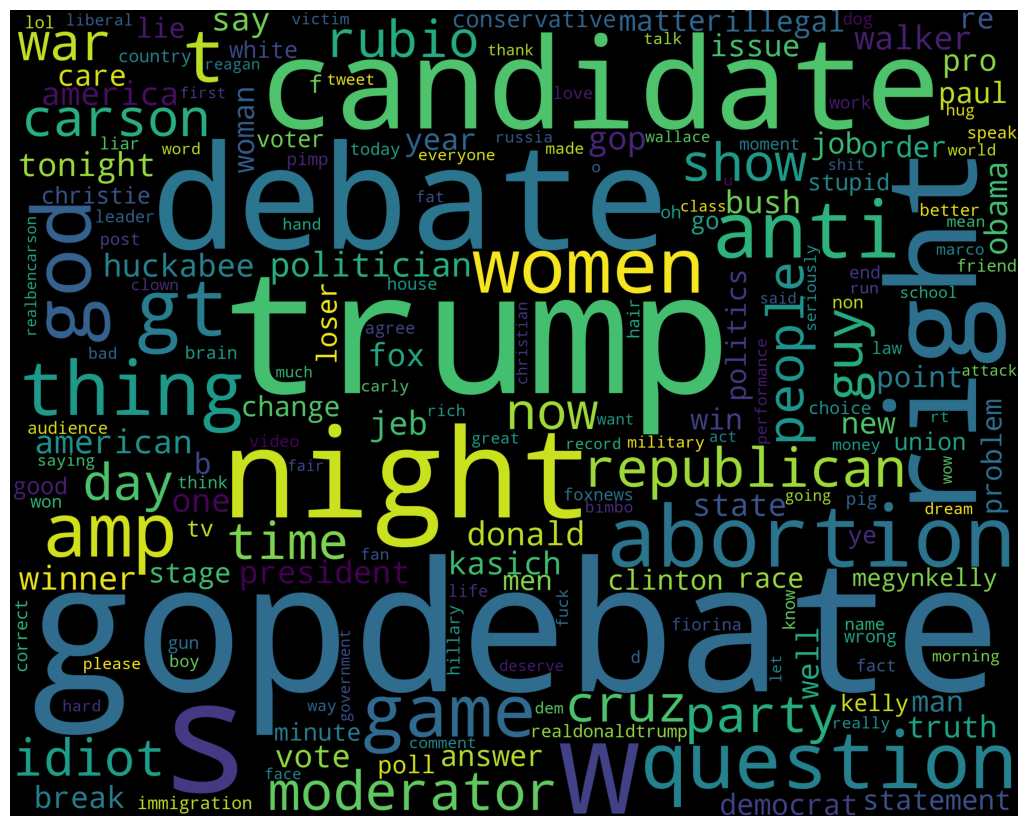

In [7]:
wordcloud_draw(w_features)

In [9]:
# Training the Naive Bayes classifier
training_set = nltk.classify.apply_features(extract_features,tweets)
classifier = nltk.NaiveBayesClassifier.train(training_set)

In [11]:
neg_cnt = 0
pos_cnt = 0
for obj in test_neg: 
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 'Negative'): 
        neg_cnt = neg_cnt + 1
for obj in test_pos: 
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 'Positive'): 
        pos_cnt = pos_cnt + 1
        
print('[Negative]: %s/%s '  % (len(test_neg),neg_cnt))        
print('[Positive]: %s/%s '  % (len(test_pos),pos_cnt))    

[Negative]: 835/797 
[Positive]: 220/77 


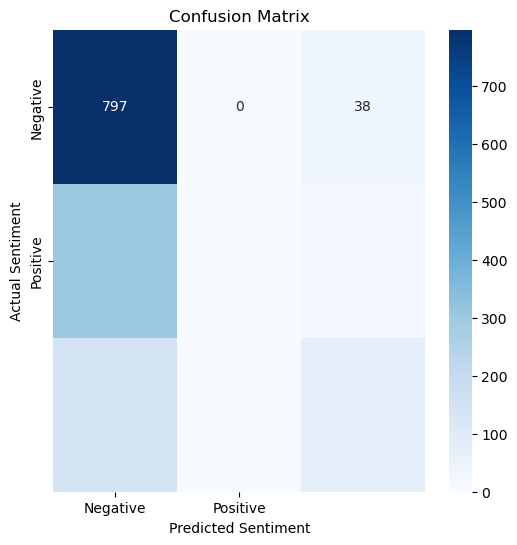

In [16]:
# Generating predictions for the test set
y_true = test['sentiment']
y_pred = [classifier.classify(extract_features(obj.split())) for obj in test['text']]

# Generating the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual Sentiment')
plt.xlabel('Predicted Sentiment')
plt.title('Confusion Matrix')
plt.show()

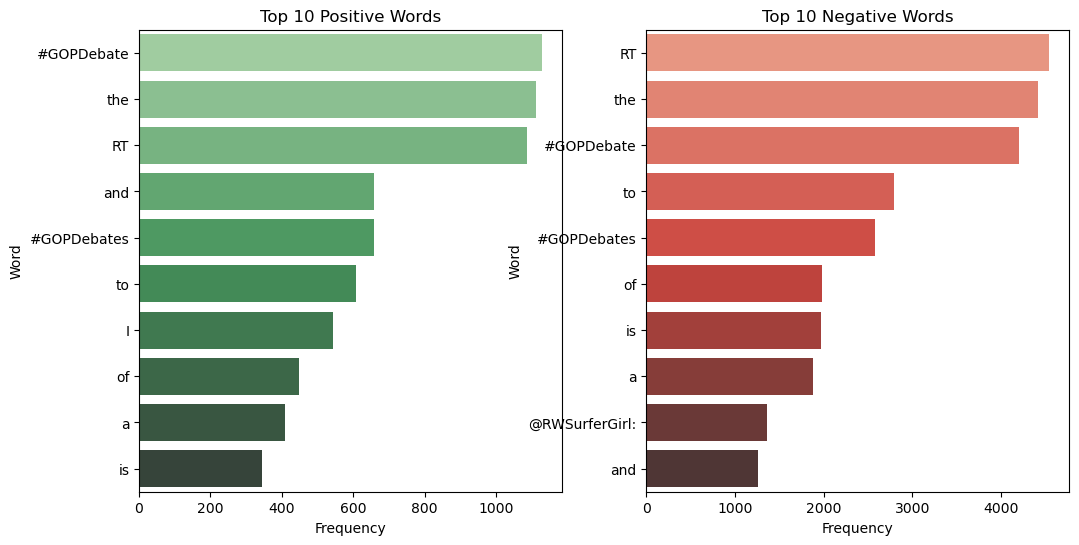

In [18]:
from collections import Counter

# Get the most common words in positive and negative tweets
pos_words = ' '.join(train_pos).split()
neg_words = ' '.join(train_neg).split()

# Count the most common words
pos_word_freq = Counter(pos_words).most_common(10)
neg_word_freq = Counter(neg_words).most_common(10)

# Plotting the word frequencies
pos_df = pd.DataFrame(pos_word_freq, columns=['Word', 'Frequency'])
neg_df = pd.DataFrame(neg_word_freq, columns=['Word', 'Frequency'])

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.barplot(x='Frequency', y='Word', data=pos_df, ax=ax[0], palette="Greens_d")
ax[0].set_title('Top 10 Positive Words')

sns.barplot(x='Frequency', y='Word', data=neg_df, ax=ax[1], palette="Reds_d")
ax[1].set_title('Top 10 Negative Words')

plt.show()

In [34]:
# Adjust the zero_division parameter to handle undefined precision/recall
print(classification_report(y_true, y_pred, target_names=['Negative', 'Neutral', 'Positive'], zero_division=1))

              precision    recall  f1-score   support

    Negative       0.64      0.95      0.77       835
     Neutral       1.00      0.00      0.00       333
    Positive       0.54      0.35      0.42       220

    accuracy                           0.63      1388
   macro avg       0.73      0.43      0.40      1388
weighted avg       0.71      0.63      0.53      1388



In [27]:
print(data['sentiment'].value_counts())

sentiment
Negative    8493
Neutral     3142
Positive    2236
Name: count, dtype: int64


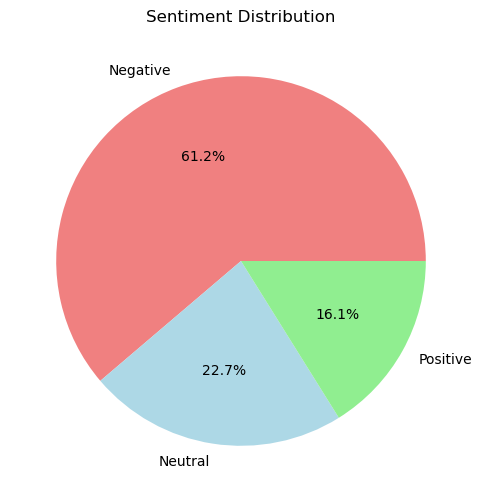

In [28]:
plt.figure(figsize=(6,6))
data['sentiment'].value_counts().plot.pie(
    autopct='%1.1f%%', 
    colors=['lightcoral', 'lightblue', 'lightgreen'], 
    labels=['Negative', 'Neutral', 'Positive']  
)
plt.title('Sentiment Distribution')
plt.ylabel('')  
plt.show()